In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression

In /Users/zhushenghua/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/zhushenghua/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/zhushenghua/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/zhushenghua/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/zhushenghu

In [2]:
df = pd.read_csv('./us_18Q1.csv')
part1 = df.iloc[:,0:28]
part2 = df.iloc[:,range(29,63,2)].fillna(2).replace({
    0:1,
    1:2,
    2:0
})
part3 = df.iloc[:,62:199]
df = pd.concat([part1,part2,part3],axis=1)

In [3]:
df['DEM_PREG'] = df['DEM_PREG'].fillna(2)
df['PAIN_CHRONIC_DOC'] = df['PAIN_CHRONIC_DOC'].fillna(0)
df['DURATION'] = (pd.to_datetime(df['DATE']) - pd.to_datetime(df['START_DATE'])).astype('timedelta64[m]')
df = df.drop(['START_DATE','DATE','DEM_STATE'],axis=1)

In [4]:
a = df.isnull().sum()/len(df)*100

variables = df.columns
variable = [ ]
for i in range(0,180):
    if a[i]<=20:
        variable.append(variables[i])
df = df[variable]

In [5]:
y = df['DAST_CAT']
x = df.drop(['DAST_SUM','DAST_CAT','DAST_1', 'DAST_2', 'DAST_3', 'DAST_4', 'DAST_5', 'DAST_6', 'DAST_7',
       'DAST_8', 'DAST_9', 'DAST_10'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.3)

In [27]:
scaler = StandardScaler()
scaler.fit(x_train)
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaler.transform(x_train), y_train)
selected_feat = x_train.columns[(sel_.get_support())]
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

/Users/zhushenghua/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SelectFromModel(estimator=LogisticRegression(C=1))

In [6]:
rf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
rf.fit(x_train, y_train)
model = SelectFromModel(rf, prefit=True)
x_train_new = model.transform(x_train)
x_test_new = x_test[x_train.iloc[:,model.get_support(True)].columns]

In [7]:
x_selected = x_train.iloc[:,model.get_support(True)].columns
print(x_selected)

Index(['DEM_AGE', 'DEM_POSTAL', 'DEM_RACE', 'DEM_INCOME', 'DEM_MARITAL',
       'DEM_EDU', 'OXY_NMU', 'HYD_NMU', 'COD_NMU', 'TOB_USE', 'ALC_USE',
       'CAN_REC_USE', 'COKE_USE', 'LSD_USE', 'HELP_SUB_USE', 'PAIN_CHRONIC',
       'PAIN_CHRONIC_DOC', 'PAIN_ACUTE', 'RXDRUGSAFE_PAIN', 'RXDRUGSAFE_THER',
       'QTIME', 'ORDER_FENT', 'ORDER_BUP', 'ORDER_METH', 'ORDER_MORPH',
       'ORDER_OXY', 'ORDER_OXYM', 'ORDER_TRAM', 'ORDER_TAP', 'ORDER_HYD',
       'ORDER_HYDM', 'ORDER_SUF', 'ORDER_COD', 'ORDER_DIHY', 'CAN_USE',
       'DEM_ZIP', 'DEM_AGE10', 'DEM_REGION', 'WT', 'DEM_DOLLARS',
       'OP_NMU_EVER', 'ILL_USE', 'DURATION'],
      dtype='object')


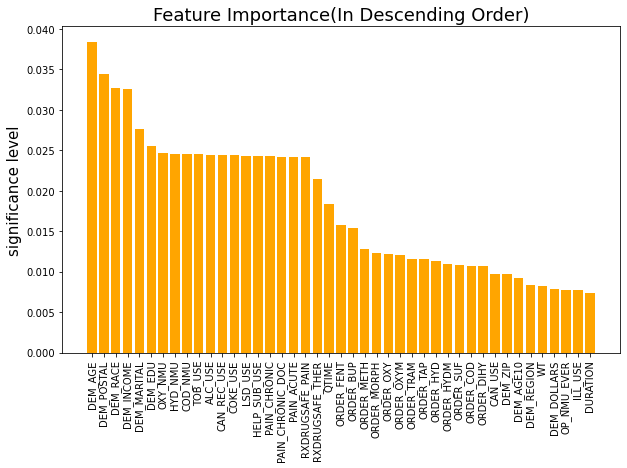

In [9]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importance(In Descending Order)",fontsize = 18)
plt.ylabel("significance level",fontsize = 15,rotation=90)
for i in range(len(x_selected)):
    plt.bar(i,importances[indices[i]],color='orange',align='center')
    plt.xticks(np.arange(len(x_selected)),x_selected,rotation=90,fontsize=10)
plt.show()

In [10]:
scores1 = cross_val_score(rf, x_train_new, y_train)
print('RandomForestClassifier CV accuracy is:'+str(scores1.mean()))

RandomForestClassifier CV accuracy is:0.6296898130830527


In [11]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 100, cv = 5, verbose=2, random_state=1, n_jobs = -1)
# rf_random.fit(x_train_new, y_train)

In [9]:
forest = RandomForestClassifier(n_estimators=1600, max_depth=None,min_samples_split=2, min_samples_leaf=1, random_state=1,n_jobs=-1)
forest.fit(x_train_new, y_train)
y_pred = forest.predict(x_test_new)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6393424414084194


In [10]:
pd.value_counts(y_pred)

1    5074
2    3771
3     123
4      27
5       8
dtype: int64